<img src="http://oci02.img.iteso.mx/identidad_de_instancia_2018/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg">

<center><font color=#555555><font size=6> Ingeniería Financiera </font> <br> <br>

<center><font color=#555555><font size=5> PAP </font> <br> <br> <br>

<center><font color=#555555><font size=5> I.F. Renatta García Sánchez </font> <br> <br>
   
<center> <font color= #555555> <font size = 4> Mayo 2020 </a> | <font color= #555555> <font size = 4> Repositorio: <a href='https://github.com/renattaGS/PAP-ML-ETICO'>Link</a></font>

<br>

---

<br>

<br>

<center> <font color= #555555> <font size = 6> Machine Learning ético </font> <br> <br> <font color= #555555>  </font>

# <font color= #555555> <font size = 5> Abstract </font>

<font color= #6B6B6B> <font size = 2> Este documento fue elaborado por Renatta García Sánchez, como trabajo para el proyecto de aplicación profesional: OPTIMIZACIÓN DE PROGRAMAS DE INVERSIÓN EN INTERMEDIARIOS FINANCIEROS, la cuál es parte del currículum de la licenciatura en Ingeniería Financiera, ofertada por la universidad **ITESO**. En el presente trabajo, se plantea la respuesta a la siguiente pregunta: </font> 

<br>

# <font color= #6B6B6B> <font size = 6> 0. Librerías y Dependencias </font>

<hr style="border:0.02in solid gray"> </hr>

# <font color= #6B6B6B> <font size = 5> 0.1 Librerías </font> <font color= #555555>

Para correr este notebook es necesario tener instaladas y/o en el archivo _requirements.txt_ las siguientes librerías :

- pandas>=1.1.1 
- pandas-profiling>=2.11.0
- jupyter>=1.0.0
- numpy>= 1.19.1
- statsmodels>=0.11.1
- openpyxl>=3.0.5
- matplotlib>=3.3.1
- scikit-learn>=0.23.2


# <font color= #6B6B6B> <font size = 5> 0.2 Dependencias </font> <font color= #555555>

Para correr este notebook es necesario contar con los siguientes archivos y dependencias externas:

- files/Datos_Techo_converted.xlsx : Datos sobre encuesta para el programa de hábitat de la organización Techo México. 

<br>

# <font color= #6B6B6B> <font size = 6> 1. Introducción </font>

<hr style="border:0.02in solid gray"> </hr>

<br>

# <font color= #6B6B6B> <font size = 6> 2. Objetivos </font>

<hr style="border:0.02in solid gray"> </hr>

<br>

# <font color= #6B6B6B> <font size = 6> 3. Datos </font>

<hr style="border:0.02in solid gray"> </hr>

Los datos con los que se trabajará, corresponde a las **Encuestas de Caracterización de Hogares (ECHS)**, correspondientes a los años 2019 y 2020 de la ONG Techo México. Éstas encuestas se realizan para determinar si una familia es candidata o no, a recibir un apoyo del programa de viviendas. Para determinar esto, se contemplan un total de 97 variables. Con excepción del año de aplicación de la ECHS, todas las variables son de tipo discreto para proteger la información que éstas contienen.

# <font color= #6B6B6B> <font size = 6> 4. Procesos </font>

<hr style="border:0.02in solid gray"> </hr>

## Lectura de datos

In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import data
import functions
import visualizations


file_path='files/Datos_Techo_converted.xlsx'

data_techo = data.lectura_datos(file_path, 'Datos Techo', 'p1')

missing_tot = (data_techo.isnull().sum()).sum()
missing = (data_techo.isnull().sum())['p74']

print('Existen un total de ', missing_tot, ' valores faltantes en el Data frame \n')
print('Existen un total de ', missing, 'valores faltnates en la columna p74')

Existen un total de  749  valores faltantes en el Data frame 

Existen un total de  749 valores faltnates en la columna p74


## Visualización de p74 (datos no faltantes)

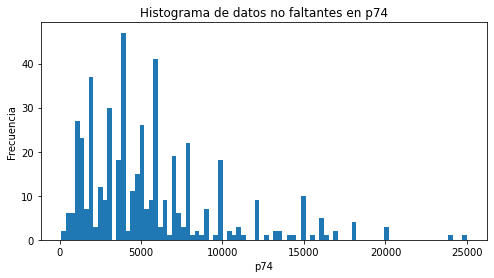

In [2]:
#Separacion de datos
ne_data = data_techo[data_techo['p74'].notnull()]['p74'].to_numpy()

#histograma
visualizations.plot_histogram_discrete(ne_data, 'p74', 'Frecuencia',
                                       'Histograma de datos no faltantes en p74')

## Datos faltantes

Dado que existe una cantidad significativa de datos faltantes en la columna p74, tenemos que proponer una estrategia para llenar estos datos, por otro lado por el tipo de datos que tenemos, es decir socio-demográficos, no podemos sencillamente llenar con un promedio o una mediana, ya que esto sería una suposición muy grande.


Por lo tanto, tras analizar el conjunto de datos, se propone llenar estos datos faltantes particionando los datos a partir de dos criterios distintos. El primer criterio será la columna p3 y la columna p27.


A partir de ésto el DataFrame se dividará en dos, los 749 registros que tienen faltantes en la columna p74 y los que sí tienen registros. Una vez realizada ésta división, se volverán a dividir los datos de acuerdo a los valores únicos de la columna p3 y éstos últimos se dividirán una segunda vez de acuerdo a la columna p27.


Una vez realizadas estas particiones, no tomamos en cuenta aquellos que no tengan datos para ser llenados, por ejemplo si para el valor 4 de la columna p3 y el valor 3 de la columna p27 no existen datos, entonces eliminaremos las columnas que tengan datos faltantes en la p74 que concidan con este criterio, dado que no tenemos suficiente información para sustentar el llenado de ésta infofrmación.


Ahora, para los criterios con los que sí contamos con información suficiente, vamos a hacer uso de la técnica de aceptación y rechazo para generar una cantidad de datos que distribuyan como los datos con los que sí contamos. La función que usaremos para el método de aceptación y rechazo la generaremos a partir del Kernel Density Estimation de la librería de statsmodels.

### Método de aceptación y rechazo

El método de la trasnformada inversa, permite generar datos que distribuyan como una función $f(x)$. Para poder aplicar este método $f(x)$ debe de ser una función acotada y con un dominio finito $a\leq x \leq b$

De acuerdo a ésta función $f(x)$ el método propone los siguientes pasos. Asuma que podemos encontrar una función $t(x)$ tal que $$t(x)\geq f(x), \quad \forall x$$ Para este caso utilizamos $t(x)$ como el valor màximo de $f(x)$.

La función $t(x)\geq 0$ no es una PDF debido a $$\int_{-\infty}^{\infty}t(x)dx\geq \int_{-\infty}^{\infty}f(x)dx =1$$ Hacemos $T(x) = c$ $$c=\int_{-\infty}^{\infty}t(x)\geq 1$$ Definamos la función $g(x)=t(x)/c \rightarrow g(x)$ es una densidad.

Resultando entonces $$\frac{f(x)}{g(x)}\leq c,\quad \forall x$$ El siguiente algoritmo genera una variable aleatoria $X$, distribuida de acuerdo a la densidad $f(x)$
1.	Generar $R_1$ teniendo densidad $g(x)$
2.	Generar $R_2 \rightarrow U \sim U(0,1)$ independiente de $R_1$ del paso 1 .
3.	Evaluar la función de probabilidad en $R_1$.
4.	Determinar si la siguiente desigualdad se cumple: $$R_2\leq \frac{f(R_1)}{t(R_1)}$$ Si la respuesta es afirmativa se utiliza $X=R_1$, de lo contrario es necesario pasar nuevamente al paso 1, tantas veces como sea necesario.
De esta forma podemos generar una cantidad $n$ de números a partir de una distribución $f(x)$

### Kernel Density Estimation

Kernerl density estimation (KDE) es una técnica estadística no paramétrica, que nos perimite estimar la función de densidad de probabilidad de una variable. A grandes rasgos ésta técinca genera una línea suave y continua, que se ajusta a la distribución de los datos (finitos). Para hacer ésto, la técnica de KDE genera líneas a partir de los datos y se va ajustando a ellos de acuerdo a la probabilidad de ocurrencia, es decir, entre mayor presencia de datos tengamos dentro de una clase KDE, infiere que existe una mayor probabilidad de ocurrrencia de ésta clase y por lo tanto va ajustando la función de acuerdo a ésto. Una parte muy importante de KDE es el kernel, a través del parámetro bandwidth (bw), es que cambia el kernel, cuando bw es bajo, se le dará más peso a aquellos puntos que se encuentren cerca de la media, cuando bw es un valor, comienza a crecer, ésto quiere decir que se le comienza a dar más peso a los valores que se encuentran más alejados de la media.

La forma en la que se calcula ésta línea o función que genera KDE, es a través de la siguiente función:
$$ \hat{ f}(x)= \sum_{observaciones} K(\frac{x- observaciones}{bandwith}) $$
Donde K representa el kernel, el kernel hace referencia a la función de distribución que se aproxima, puede ser uniforme, guassiana, triangular, etc.
En este caso utilizamos el método de cross validation maximum likelihood (MLCV), ésta se define de la siguiente forma (MLCV) $$MLCV(h) = n^{-1} \sum_{i=1}^{n} \log\left[\hat{f}_{h,i}(x)\right]$$


In [3]:
data_techo = functions.fill_empty(data_techo, 'p74', 'p3', 'p27')
missing_tot = (data_techo.isnull().sum()).sum()
print('Existen un total de ', missing_tot, ' valores faltantes en el Data frame')

Existen un total de  0  valores faltantes en el Data frame


## Visualizacion de p74 datos completos

Una vez realizado el llenado de los datos, volvemos a graficar el histograma de la columna p74

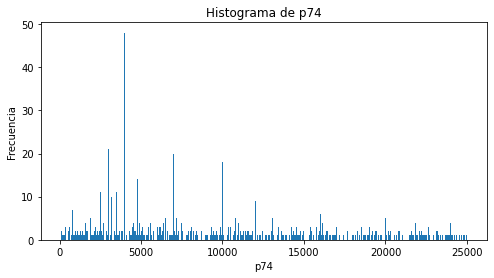

In [4]:
visualizations.plot_histogram_discrete(data_techo['p74'].to_numpy(), 'p74', 'Frecuencia',
                                       'Histograma de p74')

## Reporte de datos

Una vez realizado el llenado de nuestros datos, estamos listos para crear un reporte de las variables, para hacer ésto, nos apoyamos de la librería pandas profiling, que nos permite obener un reporte detallado de cada variable, el tipo de variable, valores únicos e histogramas. Éste reporte se encuentra dentro de la carpeta bajo el nombre de **Reporte_Datos_Techo.html**

In [5]:
data.reporte_profiling(data_techo, 'Reporte_Datos_Techo.html') 

Summarize dataset:   0%|          | 0/113 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Modelo 

En esta sección se realizarán todos los procedimientos necesarios para la creación de nuestro primer modelo de regresión logística, las variables que tomaremos en cuenta para hacer éste modelo son desde p13 hasta p128 (un total de 97 variables distintas), la variable objetivo será p131.

### Perparación de datos (prueba y entrenamiento)

El primer paso para la construcción de nuestro modelo, es separar los datos en prueba y entrenamiento, usaremos un 80% para prueba y un 20% para entrenamiento. Un punto importante en este paso, es cuidar la proporción con la que se dividen los datos, el enfoque de éste proyecto, nos lleva a prestar especial atención a este paso. Separaremos los datos de forma que se respete la proporción de las siguientes variables:

- p13


**Explicar mas citar MLBook**

Para hacer ésto nos apoyaremos de la librería sklearn, que nos permite escoger las variables sobre las cuales queremos estratificar.

In [6]:
cols_strat = ['p13']



X_train, X_test, y_train, y_test = functions.train_test_split_strat(data_techo,
                                                                    0.20, cols_strat)

features = X_train.columns.tolist()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(978, 97) (245, 97) (978,) (245,)


###  Estandirazción

Una vez particionados los datos, estandarizamos las columnas que lo requieran, ya que esta base de datos contiene muchas variables categóricas, solo es necesario estandirzar aquellas que el tipo de variable son números reales. Las variables que estandirazeremos son:


- p14
- p15
- p19
- p20
- p26
- p32
- p33
- p34
- p35
- p36
- p39
- p40
- p47
- p66
- p67
- p74
- p91
- p92
- p93
- p99
- p101
- p104

In [7]:
cols_estan = ['p14', 'p15', 'p19', 'p20', 'p26', 'p32', 'p33', 'p34', 'p35',
              'p36', 'p39', 'p40', 'p47', 'p66', 'p67', 'p74', 'p91', 'p92', 'p93',
              'p99', 'p101', 'p104']

z_train, z_test = functions.standarizacion(X_train, X_test, cols_estan)

X_train[cols_estan] = z_train
X_test[cols_estan] = z_test

### Agregamos bias a nuestra X de entrenamiento y de prueba

In [8]:
X_train['bias'] = 1
x_train = X_train[['bias'] + features].values
y_train = y_train.values
y_train = y_train.reshape(y_train.shape[0], 1)

X_test['bias'] = 1
x_test = X_test[['bias'] + features].values
y_test = y_test.values
y_test = y_test.reshape(y_test.shape[0], 1)


print('train ', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

train  (978, 98) (978, 1)
test  (245, 98) (245, 1)


### Aplicamos la función de gradiente descendiente con regularización 

Función de costo: $J(w)=-\frac{1}{m} \sum_{i=1}^{m} \big( y_i\ log(\sigma(z_i)) + (1-y_i)\ log(1-\sigma(z_i)) \big) + \frac{\lambda}{2m}\sum_{j=1}^n w_j^2$

Gradiente: $\frac{\partial J(w)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m}(\sigma(z_i) - y_i) * x_i^j + \frac{\lambda}{m}w_j$

En su forma vectorizada: $\nabla J(w)=\frac{1}{m} X^T (\sigma(z) - y) + \frac{\lambda w}{m}$

Sigmoide: $\sigma(z_i) = \frac{1}{1+e^{-z_i}}$ where $z_i=x_iw^T$

Actiaulización de pesos:

* $w_0 = w_0 - \alpha \frac{1}{m}\sum_{i=1}^{m}(\sigma(z_i) - y_i)$
* $w_j = w_j - \alpha \frac{1}{m}\sum_{i=1}^{m}(\sigma(z_i) - y_i) * x_i^j + \frac{\lambda}{m}w_j$ para $j>0$

### Entrenamiento del modelo

**Explicación**

In [9]:
w = np.random.normal(loc=1e-3, scale=1e-6, size=(1, x_train.shape[1]))
lmbd = 0.05
alpha = 0.005
epochs = 7000
print('w shape', w.shape)

print('train cost ', functions.cost(x_train, y_train, w, lmbd))
w, J, J_t = functions.gd(X_train, y_train, x_test, y_test, w, alpha, lmbd, epochs)
print('train cost ', functions.cost(X_train, y_train, w, lmbd))
w = w.reshape(-1)
print(w)

w shape (1, 98)
train cost  0.6943762960180342
train cost  0.5528215189433747
[ 0.05335863  0.17358068 -0.00500594  0.11642991  0.06624708 -0.09126096
 -0.08714453 -0.13757767  0.0401938   0.04659141 -0.4116275  -0.10158146
 -0.20916025 -0.28963901  0.07519806  0.025       0.14454073 -0.1594359
  0.16755611  0.05975421 -0.03675123  0.01815025  0.11380728  0.02733776
  0.14631644  0.03870459 -0.09825858 -0.07078739  0.01230354 -0.02248063
  0.01788397 -0.01004478  0.00825224 -0.19053139  0.23020243 -0.14697954
 -0.14504734 -0.07618231 -0.19051599  0.0577097  -0.05335928  0.09359515
  0.03043847 -0.03549879  0.02551876  0.02264854  0.06046225 -0.18647265
  0.06905541  0.19054551 -0.05013314  0.07509348 -0.10159128  0.11201398
 -0.14562082 -0.10482105 -0.01922746  0.00849843  0.16639506  0.090761
 -0.00113543 -0.15979375  0.10722958  0.01271783 -0.06459246  0.01680372
  0.02750301  0.01783822  0.18821934 -0.25700387 -0.02337286 -0.12898955
 -0.07228484  0.03364423 -0.15924903  0.19154966 

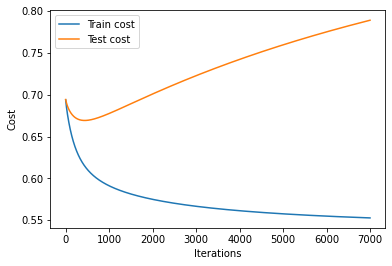

In [10]:
plt.plot(range(len(J)), J, label='Train cost')
plt.plot(range(len(J_t)), J_t, label='Test cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

### Implementamos la predicción con el modelo


En la celda siguiente, podemos observar cómo con la función h que aplica la signmoide (el clasificador utilizado) sobre nuestros datos de prueba. Ésta función nos va a regresar la probabilidad asociada a cada uno de los datos de prueba de obtener un 1 en la variable objetivo. Con esta probabilidad, establecemos un límite, es decir a partir de qué probabilidad asignaremos 1 y a partir de cuál 0. En este caso, establecemos un límite de $0.50$. Es decir que si p es mayor a $0.50$ vamos a asignar un 1, si es menor o igual a $0.50$ vamos a asignar un 0. A partir de ésto, calculamos nuestra y_hat que es la y estimada y mostramos una breve comparación de los primeros 20 resultados. La primera fila corresponde a nuestros datos reales y la segunda corresponde a los valores que usamos para probar nuestro modelo.



In [21]:
p = functions.h(x_test, w)  # get probabilities
y_hat = functions.predict(p, 0.5)
print(y_test[:20].squeeze())
print(y_hat[:20])

[0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0]
[1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0]


### Medidas de desempeño

Una vez hecha la predicción con nuestro modelo necesitamos saber qué tan bien o mal se desempeña el mismo, para ésto vamos a utilizar dos medidas de desempeño:

- sensibilidad: ésta medida nos indica la proporción de 1, que son correctamente indentificados
- especifidad: ésta medida nos indica la proporción de 0, que son correctamente identificados


Para calcular éstas medidas, necesitamos conocer la cantidad de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN). Una vez calculados éstos valores, aplicamos la fórmula para sensibilidad ($s_e$) y especifidad ($s_p$).

$$s_e = \frac{TP}{TP + FN}$$

$$s_p = \frac{TN}{TN + FP}$$

In [22]:
V = functions.get_values(y_test.reshape(-1), y_hat)
print('sensitivity', functions.sensitivity(V))
print('specificity', functions.specificity(V))

sensitivity 0.5350877192982456
specificity 0.5190839694656488


### Curva de ROC

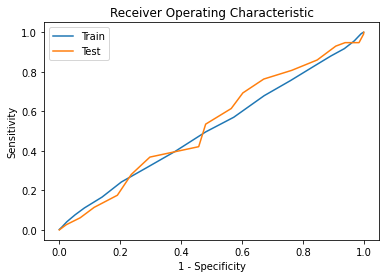

In [23]:
Se, Sp = functions.ROC(y_train, functions.h(x_train, w))
plt.plot(1 - Sp, Se, '-')

Se, Sp = functions.ROC(y_test, functions.h(x_test, w))
plt.plot(1 - Sp, Se, '-')

plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(['Train', 'Test'])
plt.title('Receiver Operating Characteristic')
plt.show()


### Area bajo la curva de ROC

In [24]:
print('Train AUC: ', metrics.roc_auc_score(y_train, functions.h(x_train, w)))
print('Test AUC: ', metrics.roc_auc_score(y_test, functions.h(x_test, w)))

Train AUC:  0.5071884447430299
Test AUC:  0.5302665059595554


# <font color= #6B6B6B> <font size = 6> 5. Conclusiones </font>

<hr style="border:0.02in solid gray"> </hr>

In [12]:
# en esta seccion es opcional incluir algun codigo para mostrar
# visualmente algun concepto o hallazgo relevante como conclusion

In [13]:
# En esta sección es opcional incluir código para mostrar/visualizar
# los datos con los que se trabajó en el laboratorio

<br>

# <font color= red> <font size = 6> 5. Pruebas (no incluir) </font>

<hr style="border:0.02in solid red"> </hr>

Las siguientes son una serie de pruebas para verificar que todo este funcionando bien, instaladas/cargadas las librerias, importar otros scripts, imprimir graficas de plotly.

In [14]:
import pandas as pd
import data as dt

In [15]:
# -- TEST 1 : 
# verify that the script is being read
print(dt.dict_test)

AttributeError: module 'data' has no attribute 'dict_test'

In [ ]:
# -- TEST 2 :
# verify that installed pandas module works correctly
df_dict_test = pd.DataFrame(dt.dict_test, index=[0,1])
print(df_dict_test)

In [ ]:
# -- TEST 3 :
# verify you can use plotly and visualize plots in jupyter notebook

import chart_studio.plotly as py  # various tools (jupyter offline print)
import plotly.graph_objects as go # plotting engine 

# example data
df = pd.DataFrame({'column_a': [1, 2, 3, 4, 5], 'column_b': [1, 2, 3, 4, 5]})
# basic plotly plot
data = [go.Bar(x=df['column_a'], y=df['column_b'])]
# instruction to view it inside jupyter
py.iplot(data, filename='jupyter-basic_bar')
# (alternatively) instruction to view it in web app of plotly
# py.plot(data)

In [ ]:
# -- TEST 4 :
# verify you can use plotly and visualize plots in web browser locally

import plotly.io as pio            # to define input-output of plots
pio.renderers.default = "browser"  # to render the plot locally in your default web browser

# basic plotly plot
plot_data = go.Figure(go.Bar(x=df['column_a'], y=df['column_b']))
# instruction to view it in specified render (in this case browser)
plot_data.show()